# Super Heroes Dataset

The goal of the task is to **predict whether a superhero is Human or not** based on their characteristics and super powers.

## Outline

- [Import Libraries and Data]
- [Feature Engineering]
    - [Data Overview]
    - [Repeated Heroes] 
    - [Handling Null Values]
    - [Categorical Variables and One-hot encoding] 
    - [All data together]
- [Modeling]
    - [Plan]
    - [Training Classifiers]
    - [Feature Importance]
    - [Dimensionality Reduction]

----------------

## Import Libraries and Data

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import cm
import seaborn as sns
import tqdm
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(rc={"figure.figsize": (10, 12)})
np.random.seed(sum(map(ord, "palettes")))

Let's call the datasets in the following way throughout the Notebook:

- Heroes Information : **`metadata`**
- Heroes Superpowers : **`powers`**

In [84]:
metadata = pd.read_csv("../data/heroes_information.csv", index_col=0)
powers = pd.read_csv("../data/super_hero_powers.csv")

-------------------

## Feature Engineering

### Data Overview

In [85]:
print("Heroes information data shape: ", metadata.shape)
print("Hero super powers data shape: ", powers.shape)

Heroes information data shape:  (734, 10)
Hero super powers data shape:  (667, 168)


In [86]:
metadata.head()

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
0,A-Bomb,Male,yellow,Human,No Hair,203.0,Marvel Comics,-,good,441.0
1,Abe Sapien,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,blue,good,65.0
2,Abin Sur,Male,blue,Ungaran,No Hair,185.0,DC Comics,red,good,90.0
3,Abomination,Male,green,Human / Radiation,No Hair,203.0,Marvel Comics,-,bad,441.0
4,Abraxas,Male,blue,Cosmic Entity,Black,-99.0,Marvel Comics,-,bad,-99.0


In [87]:
powers.head()

,hero_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
0,3-D Man,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,A-Bomb,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Abe Sapien,True,True,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Abin Sur,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Abomination,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Repeated Heroes 

As the process of dealing with Repeated Heroes is quite extensive, I created a function in the cell below that does all the work in a single step. If you would like to know the why of each action, please continue scrolling down, if not, jump to the [next section](#Handling-Null-values) .

In [88]:
def clean_repeated_heroes(metadata, powers):
    
    print("Initial shape of metadata and powers: ")
    print("Powers:", powers.shape)
    print("Metadata", metadata.shape)
    
    print("\nStart cleaning...")
    
    powers.drop_duplicates(inplace=True)
    metadata.drop_duplicates(inplace=True)
    
    # Handle Goliath
    goliath_idxs_to_drop = [100, 289, 290] # not dropping Goliath IV, it will be used to join powers
    metadata.drop(goliath_idxs_to_drop, inplace=True)
    metadata.loc[metadata.name == "Goliath IV", "Race"] = "Human"
    
    # Avoid outersected entries. i.e. appearing in metadata, but not in powers. And viceversa.
    metadata = metadata[metadata.name.isin(powers.hero_names)]
    powers = powers[powers.hero_names.isin(metadata.name)]
    
    # Spider-Man
    metadata.loc[metadata.name.str.contains("Spider-Man")] = metadata[metadata.name.str.contains("Spider-Man")].mode().values[0]
    metadata.drop(623, inplace=True)
    metadata.drop(624, inplace=True)

    # Nova
    metadata.drop(497, inplace=True)

    # Angel
    metadata.loc[metadata.name == "Angel", "Race"] = "Vampire"
    metadata.drop(23, inplace=True)

    # Blizzard
    metadata.loc[metadata.name == "Blizzard"] = metadata.loc[metadata.name == "Blizzard II"].values
    metadata.at[115, 'name'] = "Blizzard"
    metadata.at[116, 'Race'] = "Human"
    metadata.at[115, 'Race'] = "Human"
    metadata.drop(117, inplace=True)

    # Black Canary
    metadata.drop(97, inplace=True)

    # Captain Marvel
    metadata.at[156, 'Race'] = "Human"
    metadata.drop(155, inplace=True)

    # Blue Beettle
    metadata.at[122, 'Race'] = "Human"
    metadata.at[124, 'Race'] = "Human"
    metadata.at[122, 'Height'] = 183.0
    metadata.at[125, 'Height'] = 183.0
    metadata.at[122, 'Weight'] = 86.0
    metadata.at[125, 'Weight'] = 86.0
    metadata.drop(123, inplace=True)

    # Vindicator
    metadata.drop(696, inplace=True)

    # Atlas
    metadata.drop(48, inplace=True)

    # Speedy
    metadata.drop(617, inplace=True)

    # Firestorm
    metadata.drop(260, inplace=True)

    # Atom
    metadata.drop(50, inplace=True)
    metadata.at[49, 'Race'] = "Human"
    metadata.at[53, 'Race'] = "Human"
    metadata.at[54, 'Race'] = "Human"
    metadata.at[49, 'Race'] = "Human"
    metadata.at[54, 'Height'] = 183.0
    metadata.at[49, 'Height'] = 183.0
    metadata.at[53, "Weight"] = 72.0

    # Batman
    metadata.drop(69, inplace=True)

    # Toxin
    metadata.drop(673, inplace=True)

    # Namor
    metadata.drop(481, inplace=True)

    # Batgirl
    metadata.drop(62, inplace=True)
    
    print("Final shape of metadata and powers: ")
    print("Powers:", powers.shape)
    print("Metadata", metadata.shape)
    
    print("\nCleaning done")
    
    return metadata, powers

In [89]:
# if you run it twice, it won't work due to hard-coded indexers won't match.
# you need to get the data and run it again

metadata, powers = clean_repeated_heroes(metadata, powers)

Initial shape of metadata and powers: 
Powers: (667, 168)
Metadata (734, 10)

Start cleaning...
Final shape of metadata and powers: 
Powers: (643, 168)
Metadata (643, 10)

Cleaning done


-------------------------
Let's try to quickly get a glance of this by 

- Getting repeated values from `metadata`, or `powers`, in case of existing.
- Try to make sense of the difference between `metadata` and `powers` number of rows by summing the entries of the repeated rows from `metadata`.

In [90]:
powers.drop_duplicates(inplace=True)
metadata.drop_duplicates(inplace=True)

In [91]:
print("Number of rows with more than 1 entry per hero name in metadata ", (metadata.name.value_counts() > 1).sum()  )
print("Number of rows with more than 1 entry per hero name in powers ", (powers.hero_names.value_counts() > 1).sum() )

Number of rows with more than 1 entry per hero name in metadata  0
Number of rows with more than 1 entry per hero name in powers  0


In [92]:
mask = metadata.name.value_counts() > 1
metadata.name.value_counts()[mask].sum() - mask.sum() # get excessive number of rows from repeated names

0

In [93]:
# Do we have the same shape in the two datasets now?
metadata.shape[0] - powers.shape[0]
if metadata.shape[0] - powers.shape[0] == 0:
    print("Yes.")

Yes.


Checking all repeated heroes in powers dataset

In [94]:
repeated_heroes = mask.index[mask]
repeated_heroes[repeated_heroes.isin(powers.hero_names)]

Index([], dtype='object')

In [95]:
powers[powers.hero_names.str.contains("Goliath")]

,hero_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
261,Goliath IV,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [96]:
metadata[metadata.name.str.contains("Goliath")]

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
292,Goliath IV,Male,brown,Human,Black,183.0,Marvel Comics,-,good,90.0


The data contains many heroes that should be merged because they are either the same version of hero or one of it's evolutions, therefore we will unify them all into "Goliath".

In [97]:
metadata[metadata.name.str.contains("Goliath")]

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
292,Goliath IV,Male,brown,Human,Black,183.0,Marvel Comics,-,good,90.0


Looks like there are some superheroes that need to be removed from both tables as we won't have their entire information.

In [98]:
metadata = metadata[metadata.name.isin(powers.hero_names)]
powers = powers[powers.hero_names.isin(metadata.name)]

In [99]:
metadata.shape

(643, 10)

In [100]:
powers.shape

(643, 168)

Going in the good direction.

#### Merge repeated heroes into one

In [101]:
metadata.shape, powers.shape

((643, 10), (643, 168))

*Voila!*, 1-1 correspondence between both dataframes.

### Handling Null values

`metadata` has null values, represented as either '-' for all columns except for height and weight, which is `-99.0`. 

Let's take a look at how many null values there are per each column.

In [102]:
metadata = metadata.replace('-', np.nan) 
metadata = metadata.replace(-99, np.nan)

metadata.isnull().sum()

name            0
Gender         17
Eye color     122
Race          232
Hair color    124
Height        158
Publisher      13
Skin color    572
Alignment       7
Weight        180
dtype: int64

Race, which is our target in this exercise, has 232 (out of 634 rows) rows with nulls. But as for the exercise, we will ignore these. Therefore, let's drop them and then see how many null values are there still in the dataframe.

In [103]:
metadata.dropna(subset=['Race'], inplace=True)

In [104]:
metadata.isnull().sum() 

name            0
Gender          6
Eye color      54
Race            0
Hair color     55
Height         72
Publisher       8
Skin color    342
Alignment       7
Weight         89
dtype: int64

It decreased drastically. But

- Eye color and hair color still have some percentage of values missing.
- Skin color has too many values being null. It could be a potential feature to be removed. So let's just remove it.
- Height and weight have quite some null values, but they can be filled by different techniques, like the median/mean of same race and gender.

for that we will:

- Look at feature distribution of each variable to see if there can be applied any quick wins for the features with many null values.

In [105]:
# drop Skin color because it has too many null values
metadata.drop("Skin color", axis=1, inplace=True)

#### Handle Weight and Height null values

The idea is to set, for those rows which height and weight are null, the mean of the same gender and race (human / no-human). That way we will provide a good value yet still having more training data.

But first, **convert Race into label column with -> Human / No-Human**. The steps followed are:

- Everything that is Human, will be considered human. 
- Those Races that are Human-\* will also be considered human.
- All the rest, No-Human.

In [106]:
# transform Human- race into Human (as they are not mutations)
metadata.loc[:, "Race"] = metadata.apply(lambda x: "Human" if(x.Race.startswith("Human-")) else x.Race, axis=1)
# add label for modeling
metadata['label'] = metadata.apply(lambda x: "No-Human" if(x.Race != "Human") else x.Race, axis=1)

As seen, most values lie on the same range for height, for weight the deviation is a bit higher, but I would say that it is still valid to use the mean.

<AxesSubplot:title={'center':'Height'}, xlabel='label'>

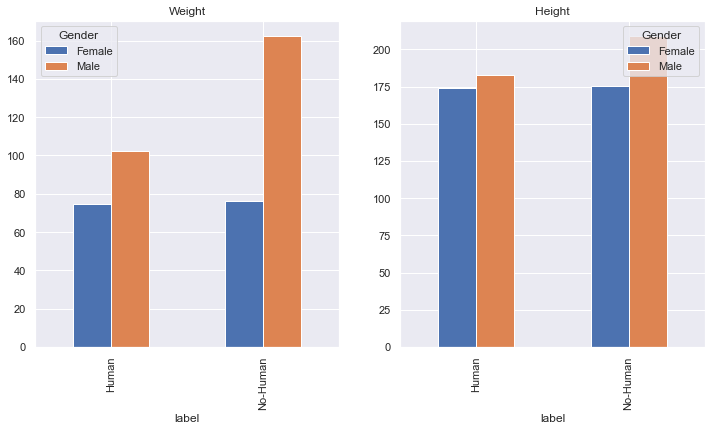

In [107]:
# height and weight can be replaced by the mean of the same gender and race

w_means = metadata.groupby(["label", "Gender"])["Weight"].mean().unstack()
h_means = metadata.groupby(["label", "Gender"])["Height"].mean().unstack()

w_fh = w_means.loc["Human","Female"]
w_mh = w_means.loc["Human","Male"]
w_fn = w_means.loc["No-Human","Female"]
w_mn = w_means.loc["No-Human","Male"]

h_fh = h_means.loc["Human","Female"]
h_mh = h_means.loc["Human","Male"]
h_fn = h_means.loc["No-Human","Female"]
h_mn = h_means.loc["No-Human","Male"]

# Fill null values with means
metadata.loc[(metadata.label == "Human") & (metadata.Gender == "Female") & (metadata.Weight.isnull()), "Weight"] = w_fh
metadata.loc[(metadata.label == "Human") & (metadata.Gender == "Male") & (metadata.Weight.isnull()), "Weight"] = w_mh
metadata.loc[(metadata.label == "No-Human") & (metadata.Gender == "Female") & (metadata.Weight.isnull()), "Weight"] = w_fn
metadata.loc[(metadata.label == "No-Human") & (metadata.Gender == "Male") & (metadata.Weight.isnull()), "Weight"] = w_mn

metadata.loc[(metadata.label == "Human") & (metadata.Gender == "Female") & (metadata.Height.isnull()), "Height"] = h_fh
metadata.loc[(metadata.label == "Human") & (metadata.Gender == "Male") & (metadata.Height.isnull()), "Height"] = h_mh
metadata.loc[(metadata.label == "No-Human") & (metadata.Gender == "Female") & (metadata.Height.isnull()), "Height"] = h_fn
metadata.loc[(metadata.label == "No-Human") & (metadata.Gender == "Male") & (metadata.Height.isnull()), "Height"] = h_mn

# plot to see clearer differences
fig, (ax1,ax2) = pyplot.subplots(1,2, figsize=(12,6))
ax1.set_title("Weight")
ax2.set_title("Height")
w_means.plot(kind="bar", ax=ax1)
h_means.plot(kind="bar", ax=ax2)


Check if we made a difference in terms of null values.

In [108]:
metadata.isnull().sum()

name           0
Gender         6
Eye color     54
Race           0
Hair color    55
Height         5
Publisher      8
Alignment      7
Weight         6
label          0
dtype: int64

As we can see, we went from 72 and 89 values for height and weight, respectivelly, to 5 and 6. And, most likely, those 5 and 6 values are due to missing Gender.

For now we could say that we can drop those rows from Gender, Height, and Weight that are null, as it will most likely be the same. Let's check it out quickly:

In [109]:
metadata[metadata.Gender.isnull()]

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Alignment,Weight,label
160,Captain Universe,NaN,NaN,God / Eternal,NaN,NaN,Marvel Comics,good,NaN,No-Human
286,Godzilla,NaN,NaN,Kaiju,NaN,108.0,NaN,bad,NaN,No-Human
410,Living Tribunal,NaN,blue,Cosmic Entity,No Hair,NaN,Marvel Comics,neutral,NaN,No-Human
426,Man of Miracles,NaN,blue,God / Eternal,Silver,NaN,Image Comics,NaN,NaN,No-Human
503,One-Above-All,NaN,NaN,Cosmic Entity,NaN,NaN,Marvel Comics,neutral,NaN,No-Human
509,Parademon,NaN,NaN,Parademon,NaN,NaN,DC Comics,bad,NaN,No-Human


Indeed, as I said. Let's then delete those rows.

In [110]:
metadata.drop(metadata[metadata.Gender.isnull()].index, axis=0, inplace=True)

Let's check how many null values do we have missing:

In [111]:
metadata.isnull().sum()

name           0
Gender         0
Eye color     50
Race           0
Hair color    51
Height         0
Publisher      7
Alignment      6
Weight         0
label          0
dtype: int64

Let's get a final check of how the values of height and weight correlate to each other, to see if there are still some weird things happening:

In [112]:
metadata[(metadata.Height > 400)]

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Alignment,Weight,label
255,Fin Fang Foom,Male,red,Kakarantharaian,No Hair,975.0,Marvel Comics,good,18.0,No-Human
272,Galactus,Male,black,Cosmic Entity,Black,876.0,Marvel Comics,neutral,16.0,No-Human
302,Groot,Male,yellow,Flora Colossus,NaN,701.0,Marvel Comics,good,4.0,No-Human


Some non-humans are really tall, but weight not too much. As they are only non-humans, let's just leave them because it won't confuse the classifier. 

What might confuse the classifier, though, it's the weight to be more than 450kg, as there are the same number of human and non-human instances. Let's take them out of the data.

In [113]:
metadata = metadata[(metadata.Weight < 450)]

#### Handling Eye and Hair color

The idea would be similar as of in Height and Weight. Let's take the most common eye and hair color

In [114]:
aux_eyes_colors = ["blue", "brown", "green"]
aux_hair_colors = ["Black", "Brown", "Blond", "Red", "No Hair"]
len_aux_eyes_colors = len(aux_eyes_colors)
len_aux_hair_colors = len(aux_hair_colors)

for ix in metadata[metadata["Eye color"].isnull()].index:
    metadata.at[ix, "Eye color"] = aux_eyes_colors[np.random.choice(len_aux_eyes_colors)]
    
for ix in metadata[metadata["Hair color"].isnull()].index:
    metadata.at[ix, "Hair color"] = aux_hair_colors[np.random.choice(len_aux_hair_colors)]


Practically no difference between the barplots shown before the methodology.

Let's now finally see what is left to handle in terms of null values:

In [116]:
metadata.isnull().sum()


name          0
Gender        0
Eye color     0
Race          0
Hair color    0
Height        0
Publisher     7
Alignment     6
Weight        0
label         0
dtype: int64

Let's just forget about the remaining rows as the number is insignificant.

In [117]:
metadata.drop(metadata[metadata.Publisher.isnull()].index, axis=0, inplace=True)
metadata.drop(metadata[metadata.Alignment.isnull()].index, axis=0, inplace=True)

In [118]:
metadata.isnull().sum()

name          0
Gender        0
Eye color     0
Race          0
Hair color    0
Height        0
Publisher     0
Alignment     0
Weight        0
label         0
dtype: int64

**Finally** Let's merge the two datasets we have after cleaning them

### Categorical Variables and One-Hot Encoding

High cardinality categorical features, we will just convert them to their corresponding code (0,1,2,...).

- Gender
- Alignment

For low cardinality features, one-hot encoding will be implemented.

- Eye color
- Hair color
- Publisher


In [119]:
metadata = metadata.drop(['Race'], axis=1)

high_card = ["Gender", "Alignment"]
low_card = ["Eye color", "Hair color", "Publisher"]

for hc in high_card:
    one_hot = pd.get_dummies(metadata[hc])
    metadata.drop(hc, axis=1, inplace=True)
    metadata = metadata.join(one_hot)

for lc in low_card:
    metadata[lc] = metadata[lc].astype('category').cat.codes

# transform label into 0 (Human) or 1 (No-Human)
metadata['label'] = metadata['label'].astype('category').cat.codes

In [120]:
# transform powers data into 0,1 binary features
cols = powers.select_dtypes(['bool']).columns
for col in cols:
    powers[col] = powers[col].astype(int)

In [121]:
metadata.head()

,name,Eye color,Hair color,Height,Publisher,Weight,label,Female,Male,bad,good,neutral
0,A-Bomb,17,11,203.000000,9,441.000000,0,0,1,0,1,0
1,Abe Sapien,2,11,191.000000,1,65.000000,1,0,1,0,1,0
2,Abin Sur,2,11,185.000000,0,90.000000,1,0,1,0,1,0
3,Abomination,7,11,203.000000,9,441.000000,1,0,1,1,0,0
4,Abraxas,2,1,208.797619,9,162.215517,1,0,1,1,0,0


In [122]:
powers.head()

,hero_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
1,A-Bomb,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abe Sapien,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abin Sur,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abomination,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Abraxas,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### All data together

In [123]:
heroes = pd.merge(metadata, powers, how='inner', left_on = 'name', right_on = 'hero_names')

heroes.drop(["hero_names","name"], axis=1, inplace=True)

powers_cols = powers.columns.drop("hero_names")
metadata_cols = metadata.columns.drop("name")

In [124]:
heroes.shape

(388, 178)

In [125]:
heroes.head()

,Eye color,Hair color,Height,Publisher,Weight,label,Female,Male,bad,good,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
0,17,11,203.000000,9,441.000000,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,11,191.000000,1,65.000000,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,11,185.000000,0,90.000000,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,7,11,203.000000,9,441.000000,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,208.797619,9,162.215517,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


And finally here, we achieved one dataset that represents both of our datasets into one.


Let's save it in case we needed it.

In [126]:
# Saving the data into a csv file 
heroes.to_csv("../data/heroes-data.csv")

## Modeling

### Plan

#### Target

The idea is to use several classifiers to predict whether the hero is Human or No-Human. 

#### Input Data

As **input data**, I will use the processed and cleaned `heroes` dataframe, which contains 388 superheroes and 179 different characteristics of each. The target is balanced between rows.


#### Models

As a baseline, we use **Logistic Regression** as it is easy to implement, understand, and should provide an already decent predictive power.

We will continue with using **SVM**, **Random Forest Classifier**, and **XGBoost**. The reason behind using those is because they are known and proven to be the most powerful conventional machine learning algorithms.

#### Feature Reduction

As our dataset has little amount of examples in comparison with the amount of features, it would be interesting to try to reduce the complexity of the dataset, to see if we predict better or not. One of the main assumptions behind dimensionality reduction is that the high complex datasets capture a lot of unnecessary information which can be reduced into a arbitrable amount of principal components that explain the variance of the underlying data, with the ideal case that the model will be trained with more rellevant information. To get a glampse of whether the dimensionality reduction will work or not, we can use t-SNE algorithm to plot high dimensionality data into two dimensions, colored by the label value (Human / Not-Human) and see if we can already infer a way to discriminate our dataset.

For the sake of reducing dimensionality, we will use the classic PCA with different amount of components and study what is the impact that it does to our dataset.

In [127]:
from sklearn.preprocessing import MinMaxScaler

X = heroes.drop(["label"], axis=1).values
y = heroes["label"].values
scaler = MinMaxScaler()
# transform data
X = scaler.fit_transform(X)
# X = preprocessing.scale(X)


### Training classifiers

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


In [147]:
# Initialize a stratified split of our dataset for the validation process
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [148]:
models = ["LogReg", "SVM", "RF"]

for model in models:
    print( "Training ", model)
    if model == "LogReg":
        clf = LogisticRegression(random_state=0, solver='liblinear')
    elif model == "SVM":
        clf = svm.SVC(kernel='linear',C=1)
    elif model == 'RF':
        clf = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=1)
    
    results = cross_val_score(clf, X, y, cv=5).mean()
    print( model, " CV accuracy score: {:.2f}%".format(results.mean()*100) )


Training  LogReg
LogReg  CV accuracy score: 71.65%
Training  SVM
SVM  CV accuracy score: 69.58%
Training  RF
RF  CV accuracy score: 76.28%


### Feature Importance

Of the best model seen, which is XGBoost.

Code obtained in kernel published by sendohchang https://www.kaggle.com/sendohchang/classify-superhero-is-a-human 

### Dimensionality Reduction

In [136]:
from sklearn.decomposition import PCA

In [142]:
heroes.columns


Index(['Eye color', 'Hair color', 'Height', 'Publisher', 'Weight', 'label',
       'Female', 'Male', 'bad', 'good',
       ...
       'Web Creation', 'Reality Warping', 'Odin Force', 'Symbiote Costume',
       'Speed Force', 'Phoenix Force', 'Molecular Dissipation',
       'Vision - Cryo', 'Omnipresent', 'Omniscient'],
      dtype='object', length=178)

In [140]:
def input_value( X ):
        pass
def Model_Input(input ,model = "LogReg", PCA = 0):
    """
        input: a numpy array that contains all the data for a prediction
    """
    if PCA == 1 :
        pca = PCA(n_components=30)
        X = pca.fit_transform(X)
    
    if model == "LogReg":
            clf = LogisticRegression(random_state=0, solver='liblinear')
    elif model == "SVM":
            clf = svm.SVC(kernel='linear',C=1)
    elif model == 'RF':
            clf = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=1)
    
    results = cross_val_score(clf, X_reduced, y, cv=5).mean()
    print( model, " CV accuracy score: {:.2f}%".format(results.mean()*100) )
    prediction = clf.predict(input)
    return prediction

In [145]:
models = ["LogReg", "SVM", "RF"]
reductions = [30, 40]

for red in reductions:
    
    print( "Applying PCA on ", red, " components")
    pca = PCA(n_components=red)
    X_reduced = pca.fit_transform(X)

    for model in models:
        print( "Training ", model )
        if model == "LogReg":
            clf = LogisticRegression(random_state=0, solver='liblinear')
        elif model == "SVM":
            clf = svm.SVC(kernel='linear',C=1)
        elif model == 'RF':
            clf = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=1)
        else:
            clf = XGBClassifier(n_estimators=50, max_depth=6)

        results = cross_val_score(clf, X_reduced, y, cv=5).mean()
        print( model, " CV accuracy score: {:.2f}%".format(results.mean()*100) )
        
    print( "\n\n" )

Applying PCA on  30  components
Training  LogReg
LogReg  CV accuracy score: 73.97%
Training  SVM
SVM  CV accuracy score: 73.70%
Training  RF
RF  CV accuracy score: 68.81%



Applying PCA on  40  components
Training  LogReg
LogReg  CV accuracy score: 73.45%
Training  SVM
SVM  CV accuracy score: 74.24%
Training  RF
RF  CV accuracy score: 69.84%



